In [1]:
import torch
import re

from torchvision import models, datasets, transforms
import os
import time

In [2]:
data_dir = 'D:/NEUB/MachineLearning/ThesisProject/x-rayImages/chest_xray/chest_xray'

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomGrayscale(p=0.05),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=(-7, 7)),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomCrop((180,180)),
        transforms.ToTensor(),
        transforms.Normalize([0.0020, 0.0020, 0.0020],[0.0010, 0.0010, 0.0010])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.0020, 0.0020, 0.0020],[0.0010, 0.0010, 0.0010])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.0020, 0.0020, 0.0020],[0.0010, 0.0010, 0.0010])
    ])
}

# Load the datasets and apply the transformations
img_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
    for x in ['train', 'val', 'test']
}

# Create data loaders
dataloaders = {
    x: torch.utils.data.DataLoader(img_datasets[x], batch_size=32, shuffle=True, num_workers=4)
    for x in ['train', 'val', 'test']
}

# Get dataset sizes
dataset_sizes = {x: len(img_datasets[x]) for x in ['train', 'val', 'test']}
print(dataset_sizes)

# Get class names
class_names = img_datasets['train'].classes
print(class_names)

# Get class names test
class_names_test = img_datasets['test'].classes
print(class_names_test)


{'train': 5216, 'val': 16, 'test': 624}
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


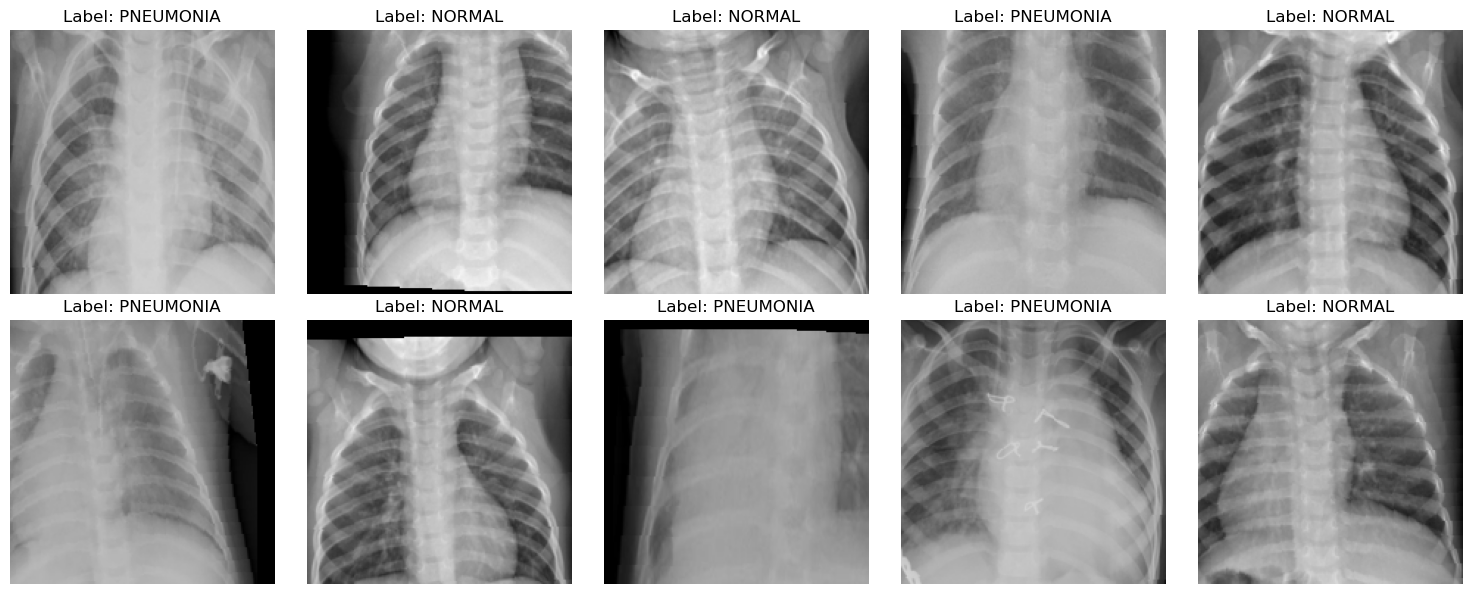

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Choose the dataset to visualize (train or val)
dataset = img_datasets['train']

# Select a few random samples from the dataset
samples = np.random.choice(len(dataset), size=10, replace=False)

# Plot the augmented images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, sample in enumerate(samples):
    row = i // 5
    col = i % 5
    
    image, label = dataset[sample]
    image = image.permute(1, 2, 0)  
    image = (image * 0.0010) + 0.0020  # Unnormalize the image
    axes[row, col].imshow(image)
    axes[row, col].set_title(f'Label: {class_names[label]}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [14]:
import torch.nn as nn
class CustomDenseNet161(nn.Module):
    def __init__(self, num_classes, custom_channels):
        super(CustomDenseNet161, self).__init__()  # Corrected the super call
        
        # Load the pretrained DenseNet-161 model
        self.base_model = models.densenet161(pretrained=True)
        
        # Remove the original classifier head
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])
        
        # Add your custom layers here
        # For example, let's add a few custom convolutional layers
        self.custom_conv1 = nn.Conv2d(custom_channels, 64, kernel_size=3, padding=1)
        self.custom_relu1 = nn.ReLU(inplace=True)
        
        # Update the number of input channels for the DenseNet model
        self.base_model[0] = nn.Conv2d(64, 96, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Define your own classifier head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(2208, 2)  # Adjust the input size accordingly
        )
    
    def forward(self, x):
        # Pass input through custom layers
        x = self.custom_conv1(x)
        x = self.custom_relu1(x)
        
        # Pass input through the DenseNet model
        x = self.base_model(x)
        
        # Pass features through the classifier head
        x = self.classifier(x)
        return x


In [15]:
num_custom_channels = 3 
num_classes = len(class_names)
print(num_classes)

custom_model = CustomDenseNet161(num_classes, num_custom_channels)


2


In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_model.parameters(), lr=0.001)


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

custom_model = custom_model.to(device)  # Replace 'model' with 'custom_model'

num_epochs = 10
best_loss = float('inf')
best_weights = None

for epoch in range(num_epochs):
    since = time.time()
    running_loss = 0.0
    running_corrects = 0
    val_loss = 0.0
    val_corrects = 0

    custom_model.train()

    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = custom_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    training_loss = running_loss / dataset_sizes['train']
    training_acc = running_corrects.double() / dataset_sizes['train']

    custom_model.eval()

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = custom_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    val_loss = val_loss / dataset_sizes['val']
    val_acc = val_corrects.double() / dataset_sizes['val']

    if val_loss < best_loss:
        best_loss = val_loss
        best_weights = custom_model.state_dict()

    print(f'Epoch {epoch + 1}/{num_epochs}: Training Loss: {training_loss:.4f} Acc: {training_acc:.4f}, '
          f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

time_elapsed = time.time() - since
print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")

# Load the best weights
custom_model.load_state_dict(best_weights)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x96 and 2208x2)